### With this Jupyter Notebook one can reproduce some graphs of the model submitted by 

Matuszynska, Saadat, Ebenhoeh, 2018 in Physiologia Plantarum using the modelbase version 

#### First import necessary packages

In [1]:
import seaborn as sns; sns.set()

In [2]:
%matplotlib inline

In [3]:
from modelbase.ode import Model, Simulator

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import copy

Could not find GLIMDA.


[1.70731708e+01 2.24895130e-04 4.99994728e+00 1.08333452e-07
 6.24306242e-08 5.03857196e-05 9.00923284e-01 9.00000000e-01
 9.00000000e-01 4.28094237e-09 5.64628407e-20 8.91538027e-13
 1.96138364e-11 1.24154015e-22 3.65029175e-01 8.39567102e-01
 4.86948919e-02 1.50791282e-17 4.72289337e-01 5.91385141e-08
 4.62249441e-07 7.74267814e-07 4.20799865e-13 3.09707126e-07]
[2.89244140e-07 9.68365876e-06 4.87913257e+00 1.08214533e-07
 2.38752041e-01 5.03738626e-05 2.70001937e-01 4.50000000e-01
 4.50000000e-01 8.65672006e-09 1.14051280e-19 2.56881509e-12
 5.65139314e-11 1.03068480e-21 3.65049050e-01 8.39612815e-01
 4.86975433e-02 7.37424772e-17 4.72436941e-01 1.00374402e-07
 7.84767316e-07 1.31448526e-06 8.48663816e-13 5.25794102e-07]
[1.70731706e+01 2.48774022e-04 4.99993372e+00 1.08411063e-07
 9.91826039e-08 5.03934524e-05 7.41980550e-01 9.99994038e-01
 5.87630605e-01 5.77128862e-09 7.61739634e-20 1.20163803e-12
 2.64360364e-11 2.25542579e-22 3.65029177e-01 8.39567106e-01
 4.86948922e-02 2.3595

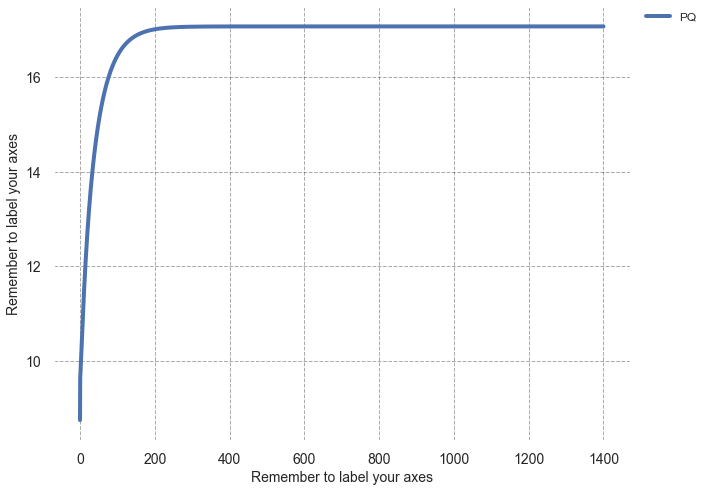

In [4]:
from y0_new_values import y0dark12, y0dark2, y0high2

## Create the model

I start with defining the compound list, as this is how I am thinking about model's structure: state variabels that describe the dynamics od the system.

In [5]:
variables = [
        #"B",  #photosystem II protein concentration
        "PQ",  # oxidised plastoquinone
        "PC",  # oxidised plastocyan
        "Fd",  # oxidised ferrodoxin
        "ATP",  # stromal concentration of ATP
        "NADPH",  # stromal concentration of NADPH
        "H",  # lumenal protons
        "LHC",#,  # non-phosphorylated antenna
        "Psbs", # PsBs
        "Vx",  #vioolaxathin relative concentration
        "PGA", 
        'BPGA', 
        'GAP', 
        'DHAP', 
        'FBP', 
        'F6P', 
        'G6P', 
        'G1P', 
        'SBP', 
        'S7P', 
        'E4P', 
        'X5P', 
        'R5P', 
        'RUBP', 
        'RU5P'
]

Next I pass the dictionary/dictionaries of parameters. You can also load them from the json file.

In [6]:
p = {"convf":3.2*10e-3, #converts ATP and NADPH
    "PSIItot": 2.5, # [mmol/molChl] total concentration of PSII
    "PSItot": 2.5,
    "PQtot": 17.5, # [mmol/molChl]
    "PCtot": 4., # Bohme1987 but other sources give different values - seems to depend greatly on organism and conditions
    "Fdtot": 5., # Bohme1987
    "Ctot": 2.5, #source unclear (Schoettler says 0.4...?, but plausible to assume that complexes (PSII,PSI,b6f) have approx. same abundance)
    "NADPtot": 0.8, # estimate from ~ 0.8 mM, Heineke1991
    "APtot": 2.55, # [mmol/molChl] Bionumbers ~2.55mM (=81mmol/molChl) (FIXME: Soma had 50)
    "Psbstot": 1., # relative pool of PsbS
    "Xtot": 1., # relative pool of carotenoids (V+A+Z)
    #Mara "ATPasetot": 1., # relative pool of ATPase

    # parameters associated with photosystem II
    "kH": 5e9,
    "kH0": 5e8, # base quenching" after calculation with Giovanni
    "kF": 6.25e8, # 6.25e7 fluorescence 16ns
    "k1": 5e9, # excitation of Pheo / charge separation 200ps
    "k1rev": 1e10,
    "k2": 5e9,#Mara was 5e10 # original 5e9 (charge separation limiting step ~ 200ps) - made this faster for higher Fs fluorescence
    "kdeg": 100,    # rate of PSII damage corresponds to p.k2 / .5e8
    "krep": 5.55e-4, # rate of repair fo PSII

    # parameters associated with photosystem I
    "kStt7": 0.0035, # [s-1] fitted to the FM dynamics
    "kPph1": 0.0013, # [s-1] fitted to the FM dynamics
    "KM_ST": 0.2, # Switch point (half-activity of Stt7) for 20% PQ oxidised (80% reduced)
    "n_ST": 2., # Hill coefficient of 4 -> 1/(2.5^4)~1/40 activity at PQox=PQred
    "staticAntI": 0.37,     # corresponds to PSI - LHCI supercomplex, when chlorophyll decreases more relative fixed antennae
    "staticAntII": 0.1,     # corresponds to PSII core
    "prob_attach": 1.,            # probability of antena attaching to PSI


     # ATP and NADPH parameters
    "kActATPase": 0.05,  # on 14.09 increased from 0.01 to saturate between 1-2 min, not 10
                            # paramter relating the rate constant of activation of the ATPase in the light
    "kDeactATPase": 0.002,   # paramter relating the deactivation of the ATPase at night
    "kATPsynth": 20.,    # taken from MATLAB
    "kATPcons": 10.,     # taken from MATLAB
    "ATPcyt": 0.5,       # only relative levels are relevant (normalised to 1) to set equilibrium
    "Pi_mol": 0.01,
    "DeltaG0_ATP": 30.6, # 30.6kJ/mol / RT
    "HPR": 14./3.,  #Vollmar et al. 2009 (after Zhu et al. 2013)
    "kNADPHcons": 15., # taken from MATLAB
    "NADPHcyt": 0.5, # only relatice levels

    # global conversion factor of PFD to excitation rate
    #"cPFD": 4. # [m^2/mmol PSII]

    # pH and protons
    "pHstroma": 7.8,
    "kLeak": 10.,#0.010, # [1/s] leakage rate -- inconsistency with Kathrine
    "bH": 100., # proton buffer: ratio total / free protons

    # rate constants
    "kPQred": 250., # [1/(s*(mmol/molChl))]
    "kCytb6f": 2.5, # a rough estimate: transfer PQ->cytf should be ~10ms
    "kPTOX": .01, # ~ 5 electrons / seconds. This gives a bit more (~20)
    "kPCox": 2500., # a rough estimate: half life of PC->P700 should be ~0.2ms
    "kFdred": 2.5e5, # a rough estimate: half life of PC->P700 should be ~2micro-s
    "kcatFNR": 500., # Carrillo2003 (kcat~500 1/s)
    "kcyc": 1.,

    "O2ext": 8., # corresponds to 250 microM cor to 20%
    "kNDH": .002, # re-introduce e- into PQ pool. Only positive for anaerobic (reducing) condition
    "kNh": 0.05,
    "kNr": 0.004,
    "NPQsw": 5.8,
    "nH": 5.,

    "EFNR": 3., # Bohme1987
    "KM_FNR_F": 1.56, # corresponds to 0.05 mM (Aliverti1990)
    "KM_FNR_N": 0.22, # corresponds to 0.007 mM (Shin1971 Aliverti2004)

    # quencher fitted parameters
    "gamma0": 0.1,          # slow quenching of Vx present despite lack of protonation
    "gamma1": 0.25,         # fast quenching present due to the protonation
    "gamma2": 0.6,          # slow quenching of Zx present despite lack of protonation
    "gamma3": 0.15,         # fastest possible quenching

    # non-photochemical quenching PROTONATION
    "kDeprotonation": 0.0096,
    "kProtonationL": 0.0096,
    "kphSatLHC": 5.8,
    "nH": 5.,
    "NPQsw": 5.8,

    # non-photochemical quenching XANTOPHYLLS
    "kDeepoxV": 0.0024,
    "kEpoxZ": 0.00024,      # 6.e-4        # converted to [1/s]
    "kphSat": 5.8,          # [-] half-saturation pH value for activity de-epoxidase highest activity at ~pH 5.8
    "kHillX": 5.,     # [-] hill-coefficient for activity of de-epoxidase
    "kHillL": 3.,     # [-] hill-coefficient for activity of de-epoxidase
    "kZSat": 0.12,          # [-] half-saturation constant (relative conc. of Z) for quenching of Z

    # standard redox potentials (at pH=0) in V
    "E0_QA": -0.140,
    "E0_PQ": 0.354,
    "E0_cytf": 0.350,
    "E0_PC": 0.380,
    "E0_P700": 0.480,
    "E0_FA": -0.550,
    "E0_Fd": -0.430,
    "E0_NADP": -0.113,

    # physical constants
    "F": 96.485, # Faraday constant
    "R": 8.3e-3, # universal gas constant
    "T": 298., # Temperature in K - for now assumed to be constant at 25 C

    # light
    "pfd": 100.,
    "Ton": 0.,
    "Toff": 1800,
    "dT": 120,

    "ox": True, # 1. means True, switched on
     
    # CBB cycle associated parameter set according to Pettersson and Pettersson 1988
    'CN': 0.5,
    'CO2': 0.2,
    'Cp': 15+2.05,#15.0
    'Ca': 0.5,
    'pHmedium': 7.6,
    'pHstroma': 7.9,
    'Pext': 0.5,

    #Vmaxes of Calvin cycle enzymes
    'V1': 0.34*8,
    'V6': 0.2*8,
    'V9': 0.04*8,
    'V13': 0.9999*8,
    'Vst': 0.04*8,
    'Vx': 0.25*8,

    #equilibrium constants of calvin cycle enzymes
    'q2': 3.1 * (10.0 ** (-4.0)),
    'q3': 1.6 * (10.0**7.0),
    'q4': 22.0,
    'q5': (7.1),
    'q7': 0.084,
    'q8': (13.0),
    'q10': 0.85,
    'q11': 0.4,
    'q12': 0.67,
    'q14': 2.3,
    'q15': 0.058,

    #michaelis constants of calvin cycle enzymes
    'Km1': 0.02,
    'KmCO2': 0.0107, #millimol laut witzel
    'Km6': 0.03,
    'Km9': 0.013,
    'Km131': 0.05,
    'Km132': 0.05,
    'Km161': 0.014,
    'Km162': 0.3,
    'Kmst1': 0.08,
    'Kmst2': 0.08,
    'Kmnadph': 0.19,#ausgerechneter wert (ideal wert)
    'Kpga': 0.25,
    'Kgap': 0.075,
    'Kdhap': 0.077,
    'Kpi': 0.63,
    'Kpxt': 0.74,
    'Ki11': 0.04,
    'Ki12': 0.04,
    'Ki13': 0.075,
    'Ki14': 0.9,
    'Ki15': 0.07,
    'Ki61': 0.7,
    'Ki62': 12.0,
    'Ki9': 12.0,
    'Ki131': 2.0,
    'Ki132': 0.7,
    'Ki133': 4.0,
    'Ki134': 2.5,
    'Ki135': 0.4,
    'Kist': 10.0,
    'Kast1': 0.1,
    'Kast2': 0.02,
    'Kast3': 0.02,

    'k': 10.0**8.0*8,
    'oxPPP': 0.
    }


## Here we define the model object

In [7]:
# modelbase 1.0
m = Model(parameters=p, compounds=variables)

In [8]:
#check the state variables
m.get_compounds()

['PQ',
 'PC',
 'Fd',
 'ATP',
 'NADPH',
 'H',
 'LHC',
 'Psbs',
 'Vx',
 'PGA',
 'BPGA',
 'GAP',
 'DHAP',
 'FBP',
 'F6P',
 'G6P',
 'G1P',
 'SBP',
 'S7P',
 'E4P',
 'X5P',
 'R5P',
 'RUBP',
 'RU5P']

In [9]:
# ====================================================================== #
# Composed parameters #
m.add_derived_parameter(
    parameter_name="RT", function=lambda r, t: r * t, parameters=["R", "T"]
)

m.add_derived_parameter(
    parameter_name="dG_pH", function=lambda r, t: np.log(10) * r * t, parameters=["R", "T"]
)

m.add_derived_parameter(
    parameter_name="Hstroma", function=lambda pHstroma: 3.2e4*10**(-pHstroma), parameters=["pHstroma"]
)

m.add_derived_parameter(
    parameter_name="kProtonation", function=lambda Hstroma: 4e-3 / Hstroma, parameters=["Hstroma"]
)

# FIX ME: we used two different definitions for H_stroma (!). This one is Nima's
m.add_derived_parameter(
    parameter_name="H_stroma", function=lambda pHstroma: (10.0**((-1.0)*pHstroma))*1000.0, parameters=["pHstroma"]
)

def keq_PQred(E0_QA, F, E0_PQ, pHstroma, dG_pH, RT):
    DG1 = -E0_QA * F
    DG2 = -2 * E0_PQ * F
    DG = -2 * DG1 + DG2 + 2 * pHstroma * dG_pH
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_PQred", function=keq_PQred, parameters=["E0_QA", "F", "E0_PQ", "pHstroma", "dG_pH", "RT"]
)

def Keq_cyc(E0_Fd, F, E0_PQ, pHstroma, dG_pH, RT):
    DG1 = -E0_Fd * F
    DG2 = -2 * E0_PQ * F
    DG = -2 * DG1 + DG2 + 2 * dG_pH * pHstroma
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_cyc", function=Keq_cyc, parameters=["E0_Fd", "F", "E0_PQ", "pHstroma", "dG_pH", "RT"]
)              

def Keq_FAFd(E0_FA, F, E0_Fd, RT):
    DG1 = -E0_FA * F
    DG2 = -E0_Fd * F
    DG = -DG1 + DG2
    K = np.exp(-DG/RT)
    return K
               
m.add_derived_parameter(
    parameter_name="Keq_FAFd", function=Keq_FAFd, parameters=["E0_FA", "F", "E0_Fd", "RT"]
)               

def Keq_PCP700(E0_PC, F, E0_P700, RT):
    DG1 = -E0_PC * F
    DG2 = -E0_P700 * F
    DG = -DG1 + DG2
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_PCP700", function=Keq_PCP700, parameters=["E0_PC", "F", "E0_P700", "RT"]
)               

def Keq_FNR(E0_Fd, F, E0_NADP, pHstroma, dG_pH, RT):
    DG1 = -E0_Fd * F
    DG2 = -2 * E0_NADP * F
    DG = -2 * DG1 + DG2 + dG_pH * pHstroma
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_FNR", function=Keq_FNR, parameters=["E0_Fd", "F", "E0_NADP", "pHstroma", "dG_pH", "RT"]
) 

def Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH)
    Keq = Pi_mol * np.exp(-DG/RT)
    return Keq

def Keq_cytb6f(pH, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    DG1 = -2 * F * E0_PQ
    DG2 = -F * E0_PC
    DG = - (DG1 + 2*dG_pH * pH) + 2 * DG2 + 2*dG_pH * (pHstroma - pH)
    Keq = np.exp(-DG/RT)
    return Keq


In [10]:
def calculate_pHstroma(x):
    return (-np.log(x*(3.2e-5))/np.log(10))    

def calculate_pHinv(x):
    return (4e3*10**(-x))

def light(pfd):
    '''
    :return: light intensity at certain point of time. 
    Typical PAM light function
    '''
    return pfd

In [11]:
def pqmoiety(PQ, pqtot):
    return pqtot - PQ

m.add_algebraic_module(
    module_name="pq_alm",
    function=pqmoiety,
    compounds=["PQ"],
    derived_compounds=["PQred"],
    modifiers=None,
    parameters=["PQtot"],
)

def pcmoiety(PC, pctot):
    return pctot - PC

m.add_algebraic_module(
    module_name="pc_alm",
    function=pcmoiety,
    compounds=["PC"],
    derived_compounds=["PCred"],
    parameters=["PCtot"],
)

def fdmoiety(Fd, fdtot):
    return fdtot - Fd

m.add_algebraic_module(
    module_name="fd_alm",
    function=fdmoiety,
    compounds=["Fd"],
    derived_compounds=["Fdred"],
    parameters=["Fdtot"],
)

def adpmoiety(ATP, atptot):
    return atptot - ATP

m.add_algebraic_module(
    module_name="adp_alm",
    function=adpmoiety,
    compounds=["ATP"],
    derived_compounds=["ADP"],
    parameters=["APtot"],
)

def nadpmoiety(NADPH, nadptot):
    return nadptot - NADPH

m.add_algebraic_module(
    module_name="nadp_alm",
    function=nadpmoiety,
    compounds=["NADPH"],
    derived_compounds=["NADP"],
    modifiers=None,
    parameters=["NADPtot"],
)

def lhcmoiety(LHC):
    return 1 - LHC

m.add_algebraic_module(
    module_name="lhc_alm",
    function=lhcmoiety,
    compounds=["LHC"],
    derived_compounds=["LHCp"]
)

def xmoiety(Vx, Xtot):
    return Xtot - Vx

m.add_algebraic_module(
    module_name="xantophylls_alm",
    function=xmoiety,
    compounds=["Vx"],
    derived_compounds=["Zx"],
    parameters=['Xtot']
)

def psbsmoiety(Psbs, Psbstot):
    return Psbstot - Psbs

m.add_algebraic_module(
    module_name="psbs_alm",
    function=psbsmoiety,
    compounds=["Psbs"],
    derived_compounds=["Psbsp"],
    parameters=['Psbstot']
)

def ps2crosssection(LHC, staticAntII, staticAntI):
    """ calculates the cross section of PSII """
    cs = staticAntII + (1 - staticAntII - staticAntI) * LHC
    return cs

m.add_algebraic_module(
    module_name="ps2crosssection",
    function=ps2crosssection,
    compounds=["LHC"],
    derived_compounds=["ps2cs"],
    modifiers=None,
    parameters=["staticAntII", "staticAntI"],
)

def quencher(Psbs, Vx, Psbsp, Zx, y0, y1, y2, y3, kZSat):
    """ 
    co-operatiove 4-state quenching mechanism
    
    Comment:
        seems like this can't reach 1, so I've checked the max value and normalized it
        for i in np.linspace(0,1,100):
            for j in np.linspace(0,1,100):
                a = np.hstack((a, vQuencher4states(p, i, j)))
        max(a)
    """
    ZAnt = Zx / (Zx + kZSat)
    Q = (y0 * Vx * Psbs + y1 * Vx * Psbsp + y2 * ZAnt * Psbsp + y3 * ZAnt * Psbs)#/0.5625
    #Q = (y0 * (1-ZAnt) * Psbs + y1 * (1-ZAnt) * Psbsp + y2 * ZAnt * Psbsp + y3 * ZAnt * Psbs)#/0.5625
    return Q

m.add_algebraic_module(
    module_name="quencher",
    function=quencher,
    compounds=["Psbs", "Vx", "Psbsp", "Zx"],
    derived_compounds=["Q"],
    modifiers=None,
    parameters=["gamma0", "gamma1", "gamma2", "gamma3", "kZSat"],
)
    

def ps2states(PQ, PQred, ps2cs, Q, PSIItot, k2, kF, _kH, Keq_PQred, kPQred, pfd, kH0):
    L = ps2cs * light(pfd)
    kH = kH0 + _kH * Q
    k3p = kPQred * PQ
    k3m = kPQred * PQred / Keq_PQred
   
    Bs = []

    
    if isinstance(kH, float) and isinstance(PQ, np.ndarray):
        kH = np.repeat(kH, len(PQ))
      
    
    for L, kH, k3p, k3m in zip(L, kH, k3p, k3m):
        M = np.array(
            [
                [-L - k3m, kH + kF, k3p, 0],
                [L, -(kH + kF + k2), 0, 0],
                [0, 0, L, -(kH + kF)],
                [1, 1, 1, 1],
            ]
        )
        A = np.array([0, 0, 0, PSIItot])
        B0, B1, B2, B3 = np.linalg.solve(M, A)
        Bs.append([B0, B1, B2, B3])
    return np.array(Bs).T


m.add_algebraic_module(
    module_name="ps2states",
    function=ps2states,
    compounds=["PQ", "PQred", "ps2cs", "Q"],
    derived_compounds=["B0", "B1", "B2", "B3"],
    parameters=["PSIItot", "k2", "kF", "kH", "Keq_PQred", "kPQred", "pfd", "kH0"],
)

def ps1states(PC, PCred, Fd, Fdred, LHC, ps2cs, PSItot, kFdred, Keq_FAFd, Keq_PCP700, kPCox, pfd):
    """ 
    QSSA calculates open state of PSI
    depends on reduction states of plastocyanin and ferredoxin
    C = [PC], F = [Fd] (ox. forms)
    accepts: light, y as an array of arrays
    returns: array of PSI open
    """
    L = (1-ps2cs) * light(pfd)

    A1 = PSItot / (1 + L/(kFdred * Fd) + (1 + Fdred/(Keq_FAFd * Fd))
                      * (PC/(Keq_PCP700 * PCred)
                         + L/(kPCox * PCred))
    )
    return A1

m.add_algebraic_module(
    module_name="ps1states",
    function=ps1states,
    compounds=["PC", "PCred", "Fd", "Fdred", "LHC", "ps2cs"],
    derived_compounds=["A1"],
    parameters=["PSItot", "kFdred", "Keq_FAFd", "Keq_PCP700", "kPCox", "pfd"],
)

def fluorescence(Q, B0, B2, ps2cs, k2, kF, kH, kH0):
    fluo = (ps2cs * kF * B0) / (kF + k2 + kH*Q) + (ps2cs * kF * B2) / (kF + kH*Q)
    return fluo

m.add_algebraic_module(
    module_name="fluorescence",
    function=fluorescence,
    compounds=["Q", "B0", "B2", "ps2cs"],
    derived_compounds=["Fluo"],
    modifiers=None,
    parameters=["k2","kF", "kH", "kH0"]
)

def calculate_pH(x):
    return (-np.log(x*(2.5e-4))/np.log(10))

m.add_algebraic_module(
    module_name="calculate_pH",
    function=calculate_pH,
    compounds=["H"],
    derived_compounds=["pH"],
    modifiers=None
)

def Pimoiety(PGA,BPGA,GAP,DHAP,FBP,F6P,G6P,G1P,SBP,S7P,E4P,X5P,R5P,RUBP,RU5P,ATP, Cp):
    return Cp - (PGA + 2*BPGA + GAP + DHAP + 2*FBP + F6P + G6P + G1P + 2*SBP + S7P + E4P + X5P + R5P + 2*RUBP + RU5P + ATP)

m.add_algebraic_module(
    module_name="pi_alm",
    function=Pimoiety,
    compounds=["PGA","BPGA","GAP","DHAP","FBP","F6P","G6P","G1P","SBP","S7P","E4P","X5P","R5P","RUBP","RU5P","ATP"],
    derived_compounds=["Pi"],
    parameters=["Cp"],
    modifiers=None
)

def Nmoiety(Pi, PGA, GAP, DHAP, Kpxt, Pext, Kpi, Kpga, Kgap, Kdhap):
    """Used several times to calculate the rate of vPGA, vGAP and vDHAP"""
    return 1+(1+(Kpxt/Pext))*((Pi/Kpi)
               +(PGA/Kpga)
               +(GAP/Kgap)
               +(DHAP/Kdhap))

m.add_algebraic_module(
    module_name="n_alm",
    function=Nmoiety,
    compounds=["Pi","PGA","GAP","DHAP"],
    derived_compounds=["N"],
    parameters=["Kpxt", "Pext", "Kpi", "Kpga", "Kgap", "Kdhap"],
    modifiers=None
)

I found it critical to introduce each occupation state of PSII as a new variable, and hence algebraic mode

In [12]:
# Rate of electron flow through the photosystems.
# Calling algebraic modules calculating excited states of each photosystem
def vPS2(B1, k2):
    """ reaction rate constant for photochemistry """
    v = 0.5 * k2 * B1
    return v

m.add_reaction(
    rate_name='vPS2',
    function=vPS2,
    stoichiometry= {"PQ":-1, "H": 2/m.get_parameter("bH")},
    dynamic_variables=["B1"],
    parameters=["k2"],
    reversible=True,
)

def vPS1(A, ps2cs, pfd):
    """ reaction rate constant for open PSI """
    L = (1-ps2cs) * light(pfd)
    v = L * A
    return v

m.add_reaction(
    rate_name='vPS1',
    function=vPS1,
    stoichiometry={"Fd": -1, "PC": 1},
    dynamic_variables=["A1", "ps2cs"],
    parameters=["pfd"],
    reversible=True,
)


In [13]:
###############################################################################
# Reaction rates
###############################################################################
def _oxygen(time, ox, O2ext, kNDH, Ton, Toff):
    """ return oxygen and NDH concentration as a function of time
    used to simulate anoxia conditions as in the paper"""
    if ox == True:
        ''' by default we assume constant oxygen supply'''
        return O2ext, kNDH
    else:
        if time<Ton or time>Toff:
            return O2ext, 0
        else:
            return 0, kNDH

##############################################################################
def oxygen(time, ox, O2ext, kNDH, Ton, Toff):
    """ return oxygen and NDH concentration as a function of time
    used to simulate anoxia conditions as in the paper"""
    if isinstance(time, (int, float)):
        return np.array(_oxygen(time, ox, O2ext, kNDH, Ton, Toff))
    else:
        return np.array(
            [
                _oxygen(t, ox, O2ext, kNDH, Ton, Toff)
                for t in time
            ]
        ).T     
        
def vPTOX(Pred, time, kPTOX, ox, O2ext, kNDH, Ton, Toff):
    """ calculates reaction rate of PTOX """
    v = Pred * kPTOX * oxygen(time, ox, O2ext, kNDH, Ton, Toff)[0] 
    return v

m.add_reaction(
    rate_name='vPTOX',
    function=vPTOX,
    stoichiometry= {"PQ": 1},
    modifiers=["PQred", "time"],
    parameters=["kPTOX", "ox", "O2ext", "kNDH", "Ton", "Toff"],
    reversible=False,
)


def vNDH(Pox, time, ox, O2ext, kNDH, Ton, Toff):
    """ 
    calculates reaction rate of PQ reduction under absence of oxygen
    can be mediated by NADH reductase NDH
    """
    v = oxygen(time, ox, O2ext, kNDH, Ton, Toff)[1] * Pox
    return v

m.add_reaction(
    rate_name='vNDH',
    function=vNDH,
    stoichiometry=  {"PQ":-1},
    modifiers=["time"],
    parameters=["ox", "O2ext", "kNDH", "Ton", "Toff"],
    reversible=False,
)


def vB6f(PC, Pox, H, Pred, PCred, pH, kCytb6f, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    """ calculates reaction rate of cytb6f """
    Keq = Keq_cytb6f(pH, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH)
    v = np.maximum(kCytb6f * (Pred * PC**2 - (Pox * PCred**2)/Keq), -kCytb6f)
    return v

m.add_reaction(
    rate_name='vB6f',
    function=vB6f,
    stoichiometry={"PC": -2, "PQ": 1, "H": 4/100},
    modifiers=["PQred", "PCred", "pH"],
    parameters=["kCytb6f", "F", "E0_PQ", "E0_PC", "pHstroma", "RT", "dG_pH"],
    reversible=True,
)

def vCyc(Pox, Fdred, kcyc):
    """
    calculates reaction rate of cyclic electron flow
    considered as practically irreversible
    """
    v = kcyc * ((Fdred**2) * Pox)
    return v

m.add_reaction(
    rate_name='vCyc',
    function=vCyc,
    stoichiometry=  {"PQ": -1, "Fd": 2},
    dynamic_variables=["PQ","Fdred"],
    parameters=["kcyc"],
    reversible=True,
)

def vFNR(Fd, Fdred, NADPH, NADP, KM_FNR_F, KM_FNR_N, EFNR, kcatFNR, Keq_FNR, convf):
    """
    Reaction rate mediated by the Ferredoxin—NADP(+) reductase (FNR)
    Kinetic: convenience kinetics Liebermeister and Klipp, 2006
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [F], [Fdred] in mmol/mol Chl/s
    [NADPH] in mM
    """
    fdred = Fdred/KM_FNR_F
    fdox = Fd/KM_FNR_F
    nadph = (NADPH/convf)/KM_FNR_N  # NADPH requires conversion to mmol/mol of chlorophyll 
    nadp = (NADP/convf)/KM_FNR_N # NADP requires conversion to mmol/mol of chlorophyll 
    v = (EFNR * kcatFNR *
        ((fdred**2) * nadp - ((fdox**2) * nadph) / Keq_FNR) /
        ((1+fdred+fdred**2) * (1+nadp) + (1+fdox+fdox**2) * (1+nadph) - 1))
    return v

m.add_reaction(
    rate_name='vFNR',
    function=vFNR,
    stoichiometry=  {"Fd": 2, "NADPH": 1*m.get_parameter('convf')},
    dynamic_variables=["Fd", "Fdred", "NADPH", "NADP"],
    parameters=["KM_FNR_F", "KM_FNR_N", "EFNR", "kcatFNR", "Keq_FNR", "convf"],
    reversible=False,
)
         

def vLeak(H, kLeak, pHstroma):
    """ 
    rate of leak of protons through the membrane
    """
    v = kLeak * (H - calculate_pHinv(pHstroma))
    return v


m.add_reaction(
    rate_name='vLeak',
    function=vLeak,
    stoichiometry= {"H": -1/m.get_parameter("bH")},
    modifiers=None,
    parameters=["kLeak", "pHstroma"],
    reversible=False,
)

def vSt12(Ant, Pox, kStt7, PQtot, KM_ST, n_ST):
    """ 
    reaction rate of state transitions from PSII to PSI
    Ant depending on module used corresponds to non-phosphorylated antennae
    or antennae associated with PSII
    """
    kKin = kStt7 * ( 1 / (1 + ((Pox /PQtot)/KM_ST)**n_ST))
    v = kKin * Ant
    return v

m.add_reaction(
    rate_name='vSt12',
    function=vSt12,
    stoichiometry= {"LHC": -1},
    modifiers=["PQ"],
    parameters=["kStt7", "PQtot", "KM_ST", "n_ST"],
    reversible=False,
)

def vSt21(LHCp, kPph1):
    """
    reaction rate of state transitions from PSI to PSII
    """
    v = kPph1 * LHCp
    return v

m.add_reaction(
    rate_name='vSt21',
    function=vSt21,
    stoichiometry= {"LHC": 1},
    dynamic_variables=["LHCp"],
    parameters=["kPph1"],
    reversible=False,
)

def vATPsynthase(ATP, ADP, pH, kATPsynth, DeltaG0_ATP, dG_pH, HPR, pHstroma,Pi_mol, RT, convf):
    """
    Reaction rate of ATP production
    Kinetic: simple mass action with PH dependant equilibrium
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [ATP], [ADP] in mM
    """    
    v = kATPsynth * (ADP/convf - ATP/convf / Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT)) #* E
    return v

m.add_reaction(
    rate_name='vATPsynthase',
    function=vATPsynthase,
    stoichiometry= {"ATP": 1*m.get_parameter('convf'), "H": -m.get_parameter('HPR')/m.get_parameter('bH')},
    dynamic_variables=["ATP","ADP","pH"],
    parameters=["kATPsynth","DeltaG0_ATP","dG_pH","HPR","pHstroma","Pi_mol","RT","convf"],
    reversible=True,
)


def vDeepox(Vx, H, nH, kDeepoxV, kphSat):
    """
    activity of xantophyll cycle: de-epoxidation of violaxanthin, modelled by Hill kinetics
    """
    vf = kDeepoxV * ((H ** nH)/ (H ** nH + calculate_pHinv(kphSat) ** nH)) * Vx
    return vf

m.add_reaction(
    rate_name='vDeepox',
    function=vDeepox,
    stoichiometry= {"Vx": -1},
    modifiers=["H"],
    parameters=["kHillX", "kDeepoxV", "kphSat"],
    reversible=False,
)

def vEpox(Zx, kEpoxZ):
    """
    activity of xantophyll cycle: epoxidation
    """
    vr = kEpoxZ * Zx
    return vr

m.add_reaction(
    rate_name='vEpox',
    function=vEpox,
    stoichiometry= {"Vx": 1},
    dynamic_variables=["Zx"],
    parameters=["kEpoxZ"],
    reversible=True,
)

def vLhcprotonation(Psbs, H, nH, kProtonationL, kphSatLHC):
    """
    activity of PsbS protein protonation: protonation modelled by Hill kinetics
    """
    vf = kProtonationL * ((H ** nH)/ (H ** nH + calculate_pHinv(kphSatLHC) ** nH)) * Psbs
    return vf

m.add_reaction(
    rate_name='vLhcprotonation',
    function=vLhcprotonation,
    stoichiometry= {"Psbs": -1},
    modifiers=["H"],
    parameters=["kHillL", "kProtonationL", "kphSatLHC"],
    reversible=False,
)

def vLhcdeprotonation(Psbsp, kDeprotonation):
    """
    activity of PsbS protein protonation: deprotonation
    """
    vr = kDeprotonation * Psbsp
    return vr

m.add_reaction(
    rate_name='vLhcdeprotonation',
    function=vLhcdeprotonation,
    stoichiometry= {"Psbs": 1},
    dynamic_variables=["Psbsp"],
    parameters=["kDeprotonation"],
    reversible=True,
)

In [14]:
""" Calvin-Benson-Bassham Cycle Reaction Rates """
def v1(RUBP, PGA, FBP, SBP, P, NADPH, V1, CO2, Km1, Ki11, Ki12, Ki13, Ki14, Ki15, KmCO2):
    """ rate of RuBisCO
    3 Ribulose-1,5-bisphosphate + 3 CO2
    -- RuBisCO -->
    6 3-Phosphoglycerate
    RuBp + CO2 -> PGA
    """
    return (V1*RUBP*CO2)/((RUBP+Km1*(1+(PGA/Ki11)+(FBP/Ki12)+(SBP/Ki13)+(P/Ki14)+(NADPH/Ki15)))*(CO2+KmCO2))

m.add_reaction(
    rate_name='vRuBisCO',
    function=v1,
    stoichiometry= {"RUBP": -1, "PGA": 2},
    dynamic_variables=["RUBP", "PGA", "FBP", "SBP", "Pi", "NADPH"],
    parameters=["V1", "CO2", "Km1", "Ki11", "Ki12", "Ki13", "Ki14", "Ki15", "KmCO2"],
    reversible=True,
)

def v2(ATP, PGA, BPGA, ADP, k, q2):
    """
    6 3-Phosphoglycerate + 6 ATP
    -- Phosphoglycerate kinase (PGK) -->
    6 1,3-Bisphosphoglycerate + 6 ADP
    PGA + ATP -> BPGA + ADP
    Assumed to be at equilibrium
    """
    return k*((ATP*PGA)-(1/q2)*(ADP*BPGA))

m.add_reaction(
    rate_name='vPGA_kinase',
    function=v2,
    stoichiometry= {"ATP": -1, "PGA": -1, "BPGA": 1},
    modifiers=["ADP"],
    parameters=["k", "q2"],
    reversible=True,
)

def v3(BPGA, NADPH, GAP, NADP, P, k, H_stroma, q3):
    """
    6 1,3-Bisphosphoglycerate + 6 NADPH + 6 H+
    -- Glyceraldehyde 3-phosphate dehydrogenase (GADPH)-->
    1 G3P + 5 Glyceraldehyde 3-phosphate
    BPGA + NADPH -> GAP + NADP
    Assumed to be at equilibrium
    Stroma pH is assumed to be constant
    """

    return k*((NADPH*BPGA*H_stroma)-(1/q3)*(GAP*NADP*P))

m.add_reaction(
    rate_name='vBPGA_dehydrogenase',
    function=v3,
    stoichiometry= {"BPGA": -1, "NADPH": -1, "GAP": 1},
    dynamic_variables=["BPGA", "NADPH", "GAP", "NADP", "Pi"],
    parameters=["k", "H_stroma", "q3"],
    reversible=True,
)

def v4(GAP, DHAP, k, q4):
    """ 
    (5) Glyceraldehyde 3-phosphate
    -- Triose phosphate isomerae (TPI)-->
    (?) Dihydroxyacetone phosphate
    GAP -> DHAP
    Assumed to be at equilibrium
    """
    return k*((GAP)-(1/q4)*(DHAP))

m.add_reaction(
    rate_name='vTPI',
    function=v4,
    stoichiometry= {"GAP": -1, "DHAP": 1},
    parameters=["k", "q4"],
    reversible=True,
)

def v5(GAP, DHAP, FBP, k, q5):
    """
    (5) Glyceraldehyde 3-phosphate + (?) Dihydroxyacetone phosphate
    -- Aldolase (ALD)-->
    Frucose 1,6-bisphosphate
    GAP + DHAP -> FBP
    Assumed to be at equilibrium
    """
    return k*((GAP*DHAP)-(1/q5)*(FBP))

m.add_reaction(
    rate_name='vAldolase',
    function=v5,
    stoichiometry= {"GAP": -1, "DHAP": -1, "FBP": 1},
    parameters=["k", "q5"],
    reversible=True,
)

def v6(FBP, F6P, P, V6, Km6, Ki61, Ki62):
    """
    (?) Fructose 1,6-bisphosphate + (?) H20
    --Fructose 1,6-bisphosphatase (FBPase) -->
    (6) Fructose 6-phosphate + (Pi)
    FBP -> F6P
    """
    return (V6*FBP)/(FBP+Km6*(1+(F6P/Ki61)+(P/Ki62)))

m.add_reaction(
    rate_name='vFBPase',
    function=v6,
    stoichiometry= {"FBP": -1, "F6P": 1},
    modifiers= ["Pi"],
    parameters=["V6", "Km6", "Ki61", "Ki62"],
    reversible=True,
)

def v7(GAP, F6P, X5P, E4P, k, q7):
    """
    (?) Fructose 6-phosphate + (?) Glyceraldehyde 3-phosphate
    -- Transketolase (TK) -->
    (?) Xylulose 5-phosphate + (?) Erythrose 4-phosphate
    GAP + F6P -> X5P + E4P
    Assumed to be at equilibrium
    """
    return k*((GAP*F6P)-(1/q7)*(X5P*E4P))

m.add_reaction(
    rate_name='vF6P_Transketolase',
    function=v7,
    stoichiometry= {"GAP": -1, "F6P": -1, "X5P": 1, "E4P": 1},
    parameters=["k", "q7"],
    reversible=True,
)

def v8(DHAP, E4P, SBP, k, q8):
    """
    (?) Dihydroxyacetone phosphate + (?) Erythrose 4-phosphate
    -- Aldolase (ALD)-->
    (?) Sedoheptulose 1,7-bisphosphate
    DHAP + E4P -> SBP
    Assumed to be at equilibrium
    """
    return k*((DHAP*E4P)-(1/q8)*(SBP))

m.add_reaction(
    rate_name='v8',
    function=v8,
    stoichiometry= {"DHAP": -1, "E4P": -1, "SBP": 1},
    parameters=["k", "q8"],
    reversible=True,
)

def v9(SBP, Pi, V9, Km9, Ki9):
    """
    (?) Sedoheptulose 1,7-bisphosphate + H20
    --Sedoheptulose 1,7-bisphosphatase (SBPase)-->
    (?) Sedoheptulose 7-phosphate + (?) Pi
    SBP -> S7P
    """

    return (V9*SBP)/(SBP+Km9*(1+(Pi/Ki9)))

m.add_reaction(
    rate_name='v9',
    function=v9,
    stoichiometry= {"SBP": -1, "S7P": 1}, #CHECKME
    dynamic_variables=["SBP","Pi"],
    parameters=["V9", "Km9", "Ki9"],
    reversible=True,
)

def v10(GAP, S7P, X5P, R5P, k, q10):
    return k*((GAP*S7P)-(1/q10)*(X5P*R5P))

m.add_reaction(
    rate_name='v10',
    function=v10,
    stoichiometry= {"GAP": -1, "S7P": -1, "X5P": 1, "R5P": 1}, 
    parameters=["k", "q10"],
    reversible=True,
)

def v11(R5P, RU5P, k, q11):
    return k*((R5P)-(1/q11)*(RU5P))

m.add_reaction(
    rate_name='v11',
    function=v11,
    stoichiometry= {"R5P": -1, "RU5P": 1}, 
    parameters=["k", "q11"],
    reversible=True,
)

def v12(X5P, RU5P, k, q12):
    return k*((X5P)-(1/q12)*(RU5P))

m.add_reaction(
    rate_name='v12',
    function=v12,
    stoichiometry= {"X5P": -1, "RU5P": 1}, 
    parameters=["k", "q12"],
    reversible=True,
)

def v13(RU5P, ATP, RUBP, PGA, P, ADP, V13, Km131, Ki131, Ki132, Ki133, Ki134, Km132, Ki135):
    return (V13*RU5P*ATP)/((RU5P+Km131*(1+(PGA/Ki131)+(RUBP/Ki132)+(P/Ki133)))*(ATP*(1+(ADP/Ki134))+Km132*(1+(ADP/Ki135))))

m.add_reaction(
    rate_name='v13',
    function=v13,
    stoichiometry= {"RU5P": -1, "ATP": -1, "RUBP": 1}, 
    modifiers=["PGA", "Pi", "ADP"],
    parameters=["V13", "Km131", "Ki131", "Ki132", "Ki133", "Ki134", "Km132", "Ki135"],
    reversible=True,
)

def v14(F6P, G6P, k, q14):
    return k*((F6P)-(1/q14)*(G6P))

m.add_reaction(
    rate_name='vG6P_isomerase',
    function=v14,
    stoichiometry= {"F6P": -1, "G6P": 1}, 
    parameters=["k", "q14"],
    reversible=True,
)

def v15(G6P, G1P, k, q15):
    return k*((G6P)-(1/q15)*(G1P))

m.add_reaction(
    rate_name='vPhosphoglucomutase',
    function=v15,
    stoichiometry= {"G6P": -1, "G1P": 1}, 
    parameters=["k", "q15"],
    reversible=True,
)

def vpga(PGA, N, Vx, Kpga):
    return (Vx*PGA)/(N*Kpga)

m.add_reaction(
    rate_name='vpga',
    function=vpga,
    stoichiometry= {"PGA": -1}, 
    modifiers=["N"],
    parameters=["Vx", "Kpga"],
    reversible=True,
)

def vgap(GAP, N, Vx, Kgap):
    return (Vx*GAP)/(N*Kgap)

m.add_reaction(
    rate_name='vgap',
    function=vgap,
    stoichiometry= {"GAP": -1}, 
    modifiers=["N"],
    parameters=["Vx", "Kgap"],
    reversible=True,
)

def vdhap(DHAP, N, Vx, Kdhap):
    return (Vx*DHAP)/(N*Kdhap)

m.add_reaction(
    rate_name='vdhap',
    function=vdhap,
    stoichiometry= {"DHAP": -1},
    modifiers=["N"],
    parameters=["Vx", "Kdhap"],
    reversible=True,
)

def vStarch(G1P, ATP, ADP, P, PGA, F6P, FBP, Vst, Kmst1, Kist, Kmst2, Kast1, Kast2, Kast3):
    """G1P -> Gn-1 ; Starch production"""
    return (Vst*G1P*ATP)/((G1P+Kmst1)*((1+(ADP/Kist))*(ATP+Kmst2)+((Kmst2*P)/(Kast1*PGA+Kast2*F6P+Kast3*FBP))))

m.add_reaction(
    rate_name='vStarch',
    function=vStarch,
    stoichiometry= {"G1P": -1, "ATP": -1}, 
    modifiers= ["ADP", "Pi", "PGA", "F6P", "FBP"],
    parameters=["Vst", "Kmst1", "Kist", "Kmst2", "Kast1", "Kast2", "Kast3"],
    reversible=False,
)

In [15]:
s = Simulator(m)

# Set initial conditions using dictionary
y0 = {
        "PQ":m.get_parameter('PQtot')/2,
        "PC":m.get_parameter('PCtot')/2,
        "Fd":m.get_parameter('Fdtot')/2,
        "ATP":0.12,
        "NADPH":0.281543418344,
        "H":calculate_pHinv(7.2),
        "LHC":0.9,
        "Psbs":0.9,
        "Vx":0.9,
        "PGA":2.15,
        'BPGA':0.000907499521924,
        'GAP':0.011839616887,
        'DHAP':0.260471552645,
        'FBP':0.11,
        'F6P':0.36,
        'G6P':0.46,
        'G1P':0.166166918189,
        'SBP':0.2,
        'S7P':0.56,
        'E4P':0.0330766864679,
        'X5P':0.0374527459593,
        'R5P':0.0627333486958,
        'RUBP':0.45,
        'RU5P':0.02,
}

In [16]:
m.get_stoichiometries_by_compounds()

{'PQ': {'vPS2': -1, 'vPTOX': 1, 'vNDH': -1, 'vB6f': 1, 'vCyc': -1},
 'H': {'vPS2': 0.02,
  'vB6f': 0.04,
  'vLeak': -0.01,
  'vATPsynthase': -0.04666666666666667},
 'Fd': {'vPS1': -1, 'vCyc': 2, 'vFNR': 2},
 'PC': {'vPS1': 1, 'vB6f': -2},
 'NADPH': {'vFNR': 0.032, 'vBPGA_dehydrogenase': -1},
 'LHC': {'vSt12': -1, 'vSt21': 1},
 'ATP': {'vATPsynthase': 0.032, 'vPGA_kinase': -1, 'v13': -1, 'vStarch': -1},
 'Vx': {'vDeepox': -1, 'vEpox': 1},
 'Psbs': {'vLhcprotonation': -1, 'vLhcdeprotonation': 1},
 'RUBP': {'vRuBisCO': -1, 'v13': 1},
 'PGA': {'vRuBisCO': 2, 'vPGA_kinase': -1, 'vpga': -1},
 'BPGA': {'vPGA_kinase': 1, 'vBPGA_dehydrogenase': -1},
 'GAP': {'vBPGA_dehydrogenase': 1,
  'vTPI': -1,
  'vAldolase': -1,
  'vF6P_Transketolase': -1,
  'v10': -1,
  'vgap': -1},
 'DHAP': {'vTPI': 1, 'vAldolase': -1, 'v8': -1, 'vdhap': -1},
 'FBP': {'vAldolase': 1, 'vFBPase': -1},
 'F6P': {'vFBPase': 1, 'vF6P_Transketolase': -1, 'vG6P_isomerase': -1},
 'X5P': {'vF6P_Transketolase': 1, 'v10': 1, 'v12': -

In [17]:
# Check quickly that the update of parameters work. 
# Changes in light intensity should affect in t=0 only rates of both photosynsthems 
# Get the initial fluxes when light is set to 100
m.update_parameter('pfd', 100)
first = m.get_fluxes_dict(y0)

# Create new model by copying the m object and increase light intensity
m2 = copy.deepcopy(m)
m2.update_parameter('pfd', 200)
second = m2.get_fluxes_dict(y0)

# this part is not needed as we used the same method to get the dictionary of fluxes, 
# but it is good to understand the the order of keys must be the same for the zip method
second_sorted = {i:second[i] for i in first.keys()}

keys = first.keys()
values = zip(first.values(), second_sorted.values())
dictionary = dict(zip(keys, values))

# Display the results in one table. I like using pandas dataframe
import pandas as pd
pd.DataFrame.from_dict(dictionary, orient='index', columns=[m.get_parameter('pfd'), m2.get_parameter('pfd')])

100.0                     200.0
vPS2                     [44.883776050392285]       [88.31784562419877]
vPS1                     [102.76796807267553]       [203.8312115577364]
vPTOX                    [0.7000000000000001]      [0.7000000000000001]
vNDH                                 [0.0175]                  [0.0175]
vB6f                      [87.49999999999885]       [87.49999999999885]
vCyc                                [54.6875]                 [54.6875]
vFNR                      [474.8957300147854]       [474.8957300147854]
vLeak                 [0.0020202592132031053]   [0.0020202592132031053]
vSt12                 [0.0004344827586206897]   [0.0004344827586206897]
vSt21                [0.00012999999999999996]  [0.00012999999999999996]
vATPsynthase             [-956396.4323218087]      [-956396.4323218087]
vDeepox               [2.159999784000012e-10]   [2.159999784000012e-10]
vEpox                [2.3999999999999994e-05]  [2.3999999999999994e-05]
vLhcprotonation       [5.451127513414827e-07]   [5.451127513414827e-07]
vLhcdeprotonation     [0.0009599999999999997]   [0.0009599999999999997]
vRuBisCO                 [0.5854332069750189]      [0.5854332069750189]
vPGA_kinase              [-5484500227.807278]      [-5484500227.807278]
vBPGA_dehydrogenase     [-0.8907456522948141]     [-0.8907456522948141]
vTPI                      [0.686145454342757]       [0.686145454342757]
vAldolase                [-9927259.482560018]      [-9927259.482560018]
vFBPase                  [0.9583724304693442]      [0.9583724304693442]
vF6P_Transketolase        [-8388406.86471233]       [-8388406.86471233]
v8                      [-5415263.6031756895]     [-5415263.6031756895]
v9                       [0.2841577846276371]      [0.2841577846276371]
v10                       [3092820.203606606]       [3092820.203606606]
v11                      [10186678.956639994]      [10186678.956639994]
v12                        [6081599.75251463]        [6081599.75251463]
v13                     [0.10949675284234942]     [0.10949675284234942]
vG6P_isomerase           [127999999.99999996]      [127999999.99999996]
vPhosphoglucomutase     [-1923957492.2620687]     [-1923957492.2620687]
vpga                     [0.2277003055731427]      [0.2277003055731427]
vgap                   [0.004179665710137738]    [0.004179665710137738]
vdhap                   [0.08956425872905079]     [0.08956425872905079]
vStarch               [0.0060671621969625444]   [0.0060671621969625444]

## Simulations

In [18]:
#light = [100, 200, 500, 750, 1000]
light_intens = [100, 200, 500, 750, 1000]

In [19]:
y = dict()

In [20]:
y['State1'] = {}
for x in light_intens:
    s = Simulator(m)
    s.update_parameter("pfd", x)
    s.initialise(y0dark12)
    s.update_parameters({"kProtonationL": 0.0, "kDeprotonation": 0.0, "kDeepoxV": 0.0, "kEpoxZ": 0.0})
    s.simulate(900, steps=10000, **{'atol':1.e-12})
    s.update_parameter("pfd", 30.0)
    s.simulate(1400, steps=10000, **{'atol':1.e-12})
    y['State1'][x] =  {'ATP': s.get_variable('ATP'), 't': s.get_time()} # store the actual time of the simulation

In [21]:
y['State2'] = {}
for x in light_intens:
    s = Simulator(m)
    s.update_parameter("pfd", x)
    s.initialise(y0dark2)
    s.update_parameters({"kProtonationL": 0.0, "kDeprotonation": 0.0, "kDeepoxV": 0.0, "kEpoxZ": 0.0})
    s.simulate(900, steps=100000, **{'atol':1.e-20})
    s.update_parameter("pfd", 30.0)
    s.simulate(1400, steps=100000, **{'atol':1.e-20})
    y['State2'][x] =  {'ATP': s.get_variable('ATP'), 't': s.get_time()} # store the actual time of the simulation

In [22]:
y['StateNPQ'] = {}
for x in light_intens:
    s = Simulator(m)
    s.update_parameter("pfd", x)
    s.initialise(y0high2)
    s.update_parameters({"kProtonationL": 0.0096, "kDeprotonation": 0.0096, "kDeepoxV": 0.0024, "kEpoxZ": 0.00024})
    s.simulate(900, steps=10000, **{'atol':1.e-20})
    s.update_parameter("pfd", 30.0)
    s.simulate(1400, steps=10000, **{'atol':1.e-20})
    y['StateNPQ'][x] =  {'ATP': s.get_variable('ATP'), 't': s.get_time()} # store the actual time of the simulation

## with PAM

In [23]:
Tmax =1400
dt = 60
pulse=0.8
Tdark = 900

In [24]:
yPAM = dict()

In [25]:
init_cond ={'y0':y0dark12,
           't0': 0}

In [26]:
yPAM['State1'] = {}
for x in light_intens:
    t = init_cond['t0']
    s = Simulator(m)
    s.update_parameter("pfd", x)
    s.initialise(y0dark12)
    s.update_parameters({"kProtonationL": 0.0, "kDeprotonation": 0.0, "kDeepoxV": 0.0, "kEpoxZ": 0.0})
    while t < Tmax:
        if t%dt == 0:
            s.update_parameter("pfd", 5000)
            s.simulate(t+pulse, steps=10000, **{'atol':1.e-20})
        else:
            if t < Tdark:
                s.update_parameter("pfd", x)
            else:
                s.update_parameter("pfd", 30.0)
            s.simulate(t+dt-pulse, steps=10000, **{'atol':1.e-20})
        t = s.get_time()[-1]
    yPAM['State1'][x] =  {'ATP': s.get_variable('ATP'), 't': s.get_time()} # store the actual time of the simulation

In [27]:
yPAM['State2'] = {}
for x in light_intens:
    t = init_cond['t0']
    s = Simulator(m)
    s.update_parameter("pfd", x)
    s.initialise(y0dark2)
    s.update_parameters({"kProtonationL": 0.0, "kDeprotonation": 0.0, "kDeepoxV": 0.0, "kEpoxZ": 0.0})
    while t < Tmax:
        if t%dt == 0:
            s.update_parameter("pfd", 5000)
            s.simulate(t+pulse, steps=10000, **{'atol':1.e-20})
        else:
            if t < Tdark:
                s.update_parameter("pfd", x)
            else:
                s.update_parameter("pfd", 30.0)
            s.simulate(t+dt-pulse, steps=10000, **{'atol':1.e-20})
        t = s.get_time()[-1]
    yPAM['State2'][x] =  {'ATP': s.get_variable('ATP'), 't': s.get_time()} # store the actual time of the simulation

In [28]:
yPAM['StateNPQ'] = {}
for x in light_intens:
    t = init_cond['t0']
    s = Simulator(m)
    s.update_parameter("pfd", x)
    s.initialise(y0high2)
    s.update_parameters({"kProtonationL": 0.0096, "kDeprotonation": 0.0096, "kDeepoxV": 0.0024, "kEpoxZ": 0.00024})
    while t < Tmax:
        if t%dt == 0:
            s.update_parameter("pfd", 5000)
            s.simulate(t+pulse, steps=10000, **{'atol':1.e-20})
        else:
            if t < Tdark:
                s.update_parameter("pfd", x)
            else:
                s.update_parameter("pfd", 30.0)
            s.simulate(t+dt-pulse, steps=10000, **{'atol':1.e-20})
        t = s.get_time()[-1]
    yPAM['StateNPQ'][x] =  {'ATP': s.get_variable('ATP'), 't': s.get_time()} # store the actual time of the simulation

## Plot

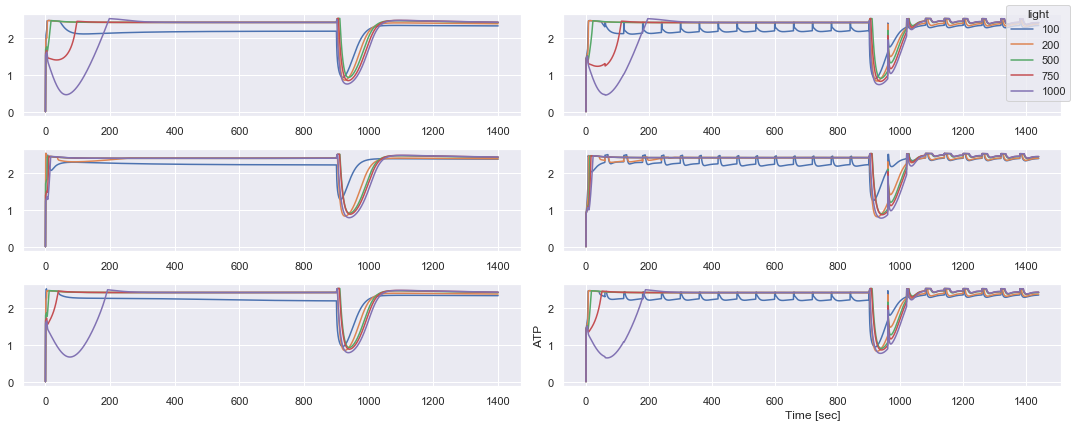

In [29]:
fig, axs = plt.subplots(3,2, figsize=(15, 6), facecolor='w', edgecolor='k')

j = 0
cnt = 0
for i in light_intens: # this is more flexible. If I tell you to include mor elight inetnsities, you just need to ammend the light list
    axs[j][0].plot(y['State1'][i]['t'],y['State1'][i]['ATP'], label=i)
    axs[+1][0].plot(y['State2'][i]['t'],y['State2'][i]['ATP'])
    axs[j+2][0].plot(y['StateNPQ'][i]['t'],y['StateNPQ'][i]['ATP'])
    
    axs[j][1].plot(yPAM['State1'][i]['t'],yPAM['State1'][i]['ATP'])
    axs[j+1][1].plot(yPAM['State2'][i]['t'],yPAM['State2'][i]['ATP'])
    axs[j+2][1].plot(yPAM['StateNPQ'][i]['t'],yPAM['StateNPQ'][i]['ATP'])
    cnt += 1

fig.legend(title='light')#, ncol=3) # add the title to your legend and you can always play with number fo columns if you want to
plt.xlabel("Time [sec]")
plt.ylabel("ATP")
fig.tight_layout()